### Обзор 3
Этот ноутбук посвящён подбору гиперпараметров модели XGBoost с помощью Optuna. Модель предназначена для прогнозирования цен на жильё. В качестве входных данных используются предварительно обработанные данные из ноутбука Sales_House_EDA.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [11]:
pip install shap


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ---------------------------------------- 0.0/547.8 kB ? eta -:--:--
   ------------------- -------------------- 262.1/547.8 kB ? eta -:--:--
   -------------------------------------- 547.8/547.8 kB 964.2 kB/s eta 0:00:00

   ---------------------------------------- 0/2 [slicer]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score

In [3]:
import pandas as pd
# Загружаем готовый предобработанный набор
df_baseline = pd.read_csv("data/Preprocessed_Data.csv")

df_baseline.sample(10)


,baths,sqft,beds,stories,target,target_log,has_private_pool,has_fireplace,status_active,status_coming soon,...,Year_built_clean,house_age,Remodeled_year_clean,years_since_remodel,Heating_LE,Cooling_LE,Parking_LE,zipcode_avg_price,zipcode_median_price,zipcode_LE
20094,2.229093,4.256605,3.316421,0.181673,1499000.0,14.220309,True,True,False,False,...,1981.0,44.0,1965.0,60.0,6.0,1.0,4.0,13.020511,12.992257,2789
238955,-0.461336,-0.693234,2.423935,-1.189598,199900.0,12.205578,False,False,True,False,...,1961.0,64.0,1985.0,40.0,5.0,1.0,6.0,12.092801,12.205077,1155
262710,-0.461336,-0.870404,-0.253523,0.181673,105000.0,11.561725,False,False,False,False,...,1973.0,52.0,1987.0,38.0,10.0,5.0,0.0,12.254257,12.196027,3068
345484,-0.461336,-0.954251,-0.253523,1.552944,599000.0,13.303019,False,False,True,False,...,2006.0,19.0,1925.0,100.0,0.0,1.0,0.0,13.969003,14.115616,207
136462,-0.461336,-0.733334,-1.146009,-1.189598,118000.0,11.678448,False,False,True,False,...,1981.0,44.0,1981.0,44.0,5.0,1.0,6.0,11.736319,11.898195,1571
82942,1.152921,2.436779,1.531449,0.181673,4395000.0,15.295978,False,True,True,False,...,2005.0,20.0,2005.0,20.0,5.0,1.0,5.0,13.515629,13.493928,1588
257668,0.076750,0.249488,0.638963,0.181673,250000.0,12.429220,False,False,True,False,...,1973.0,52.0,1985.0,40.0,9.0,1.0,5.0,12.131933,12.071975,1210
26075,-0.461336,1.649354,-0.253523,0.181673,1995000.0,14.506155,False,True,True,False,...,1940.0,85.0,2000.0,25.0,10.0,10.0,0.0,14.165418,14.077876,4352
283729,-0.461336,-0.715836,-0.253523,-1.189598,139700.0,11.847260,False,False,True,False,...,1977.0,48.0,1992.0,33.0,10.0,1.0,10.0,11.870415,11.967187,1113
231935,-0.461336,-0.179221,-0.253523,-1.189598,289900.0,12.577295,False,True,False,False,...,2009.0,16.0,1965.0,60.0,6.0,1.0,3.0,12.807240,12.778466,2801


In [4]:
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351814 entries, 0 to 351813
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       351814 non-null  float64
 1   sqft                        351814 non-null  float64
 2   beds                        351814 non-null  float64
 3   stories                     351814 non-null  float64
 4   target                      351814 non-null  float64
 5   target_log                  351814 non-null  float64
 6   has_private_pool            351814 non-null  bool   
 7   has_fireplace               351814 non-null  bool   
 8   status_active               351814 non-null  bool   
 9   status_coming soon          351814 non-null  bool   
 10  status_new                  351814 non-null  bool   
 11  status_other                351814 non-null  bool   
 12  status_pending              351814 non-null  bool   
 13  status_sold   

In [5]:
df_baseline.describe(include='all')

,baths,sqft,beds,stories,target,target_log,has_private_pool,has_fireplace,status_active,status_coming soon,...,Year_built_clean,house_age,Remodeled_year_clean,years_since_remodel,Heating_LE,Cooling_LE,Parking_LE,zipcode_avg_price,zipcode_median_price,zipcode_LE
count,351814.000000,351814.000000,351814.000000,351814.000000,3.518140e+05,351814.000000,351814,351814,351814,351814,...,3.518140e+05,3.518140e+05,351814.000000,351814.000000,351814.000000,351814.000000,351814.000000,351814.000000,351814.000000,351814.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,310450,253429,287382,351723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,-0.000019,-0.000103,-0.000004,-0.000015,6.579760e+05,12.710360,NaN,NaN,NaN,NaN,...,3.185427e+06,-3.183402e+06,1984.858448,40.141552,4.808581,2.317418,3.292584,12.710360,12.714875,2114.181693
std,0.999953,0.999717,0.999972,1.000041,1.848664e+06,1.143615,NaN,NaN,NaN,NaN,...,1.335176e+09,1.335176e+09,66.277302,66.277302,3.589603,3.298038,3.591026,0.845644,0.833898,1117.637762
min,-0.999422,-1.572525,-2.038496,-1.189598,1.000000e+00,0.693147,NaN,NaN,NaN,NaN,...,1.000000e+00,-5.599906e+11,0.000000,4.000000,0.000000,0.000000,0.000000,8.006701,6.908755,0.000000
25%,-0.461336,-0.575849,-0.253523,-1.189598,1.990000e+05,12.201065,NaN,NaN,NaN,NaN,...,1.958000e+03,1.900000e+01,1978.000000,21.000000,0.000000,0.000000,0.000000,12.278800,12.314483,1385.000000
50%,-0.461336,-0.260879,-0.253523,0.181673,3.379000e+05,12.730508,NaN,NaN,NaN,NaN,...,1.987000e+03,3.800000e+01,1990.000000,35.000000,5.000000,1.000000,3.000000,12.732553,12.721590,1757.000000
75%,0.076750,0.244385,0.638963,0.181673,6.390000e+05,13.367661,NaN,NaN,NaN,NaN,...,2.006000e+03,6.700000e+01,2004.000000,47.000000,8.000000,2.000000,5.000000,13.196041,13.161586,2971.000000


Train R²: 0.8381973699678973
Train MAE: 0.2798030465066303


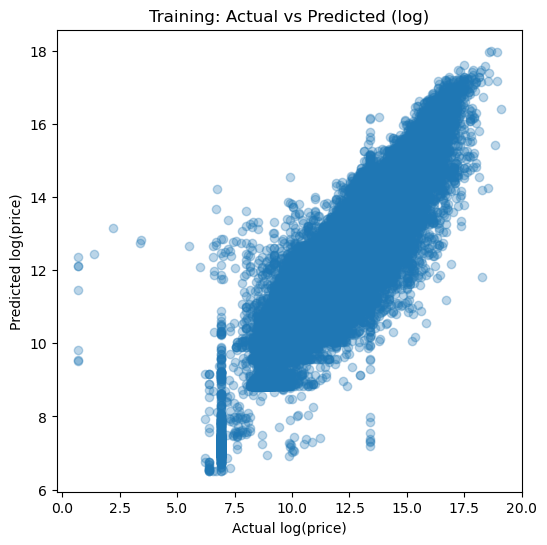

Test R²: 0.8299795752270576
Test MAE: 0.28553444008648243


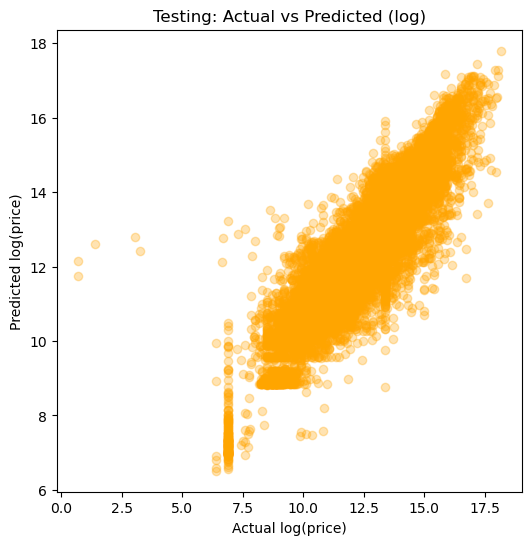

Train RMSE (price units): 1257551.58
Test RMSE  (price units): 1126334.86


In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRegressor

# --------------------------
# 1. Подготовка данных
# --------------------------
import pandas as pd
# Загружаем готовый предобработанный набор
df_baseline = pd.read_csv("data/Preprocessed_Data.csv")

df_baseline.sample(10)
# X = все признаки, кроме target и target_log
X = df_baseline.drop(['target', 'target_log'], axis=1)
y = df_baseline['target_log']  # прогнозируем логарифм цены

# Разделение на train и test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 2. Создание и обучение модели
# --------------------------
model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    objective='reg:squarederror'  # для регрессии MSE
)

# Обучение на train
model.fit(X_train, Y_train)

# --------------------------
# 3. Оценка на обучающих данных
# --------------------------
training_data_prediction = model.predict(X_train)

score_r2_train = metrics.r2_score(Y_train, training_data_prediction)
score_mae_train = metrics.mean_absolute_error(Y_train, training_data_prediction)

print('Train R²:', score_r2_train)
print('Train MAE:', score_mae_train)

# Визуализация
plt.figure(figsize=(6,6))
plt.scatter(Y_train, training_data_prediction, alpha=0.3)
plt.xlabel("Actual log(price)")
plt.ylabel("Predicted log(price)")
plt.title("Training: Actual vs Predicted (log)")
plt.show()

# --------------------------
# 4. Оценка на тестовых данных
# --------------------------
test_data_prediction = model.predict(X_test)

score_r2_test = metrics.r2_score(Y_test, test_data_prediction)
score_mae_test = metrics.mean_absolute_error(Y_test, test_data_prediction)

print('Test R²:', score_r2_test)
print('Test MAE:', score_mae_test)

# Визуализация
plt.figure(figsize=(6,6))
plt.scatter(Y_test, test_data_prediction, alpha=0.3, color='orange')
plt.xlabel("Actual log(price)")
plt.ylabel("Predicted log(price)")
plt.title("Testing: Actual vs Predicted (log)")
plt.show()

# --------------------------
# 5. Если нужны метрики в реальных ценах
# --------------------------
Y_train_price = np.exp(Y_train)
pred_train_price = np.exp(training_data_prediction)

Y_test_price = np.exp(Y_test)
pred_test_price = np.exp(test_data_prediction)

rmse_train_price = np.sqrt(metrics.mean_squared_error(Y_train_price, pred_train_price))
rmse_test_price = np.sqrt(metrics.mean_squared_error(Y_test_price, pred_test_price))

print(f"Train RMSE (price units): {rmse_train_price:.2f}")
print(f"Test RMSE  (price units): {rmse_test_price:.2f}")


# FINAL эксперимент

In [3]:
# --------------------------
# 1. Импорт библиотек
# --------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna

# --------------------------
# 2. Подготовка данных
# --------------------------
X = df_baseline.drop(['target', 'target_log'], axis=1)
y = df_baseline['target_log']  # прогнозируем логарифм цены

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 3. Функция для оценки модели
# --------------------------
def rmse_cv_score(model, X, y, cv=3):
    """Cross-validated RMSE"""
    scores = cross_val_score(
        model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1
    )
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

# --------------------------
# 4. Функция Optuna
# --------------------------
def objective(trial):
    # Hyperparameters XGB
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "objective": "reg:squarederror",
        "n_jobs": -1
    }

    model = XGBRegressor(**params)
    rmse_mean = rmse_cv_score(model, X_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=42))
    return rmse_mean

# --------------------------
# 5. Создание и запуск Optuna study
# --------------------------
study = optuna.create_study(direction="minimize", study_name="xgb_rmse_logprice")
study.optimize(objective, n_trials=50, n_jobs=1)  # n_trials можно увеличить для более точного подбора

print("Best trial:")
trial = study.best_trial
print("  RMSE:", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# --------------------------
# 6. Обучение финальной модели с лучшими гиперпараметрами
# --------------------------
best_params = trial.params
final_model = XGBRegressor(**best_params, random_state=42, objective='reg:squarederror', n_jobs=-1)
final_model.fit(X_train, y_train)

# --------------------------
# 7. Оценка модели
# --------------------------
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

from sklearn.metrics import r2_score, mean_absolute_error
print("Train R²:", r2_score(y_train, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred))

# --------------------------
# 8. RMSE в реальных ценах
# --------------------------
y_train_price = np.exp(y_train)
y_test_price = np.exp(y_test)
pred_train_price = np.exp(y_train_pred)
pred_test_price = np.exp(y_test_pred)

train_rmse_price = np.sqrt(mean_squared_error(y_train_price, pred_train_price))
test_rmse_price = np.sqrt(mean_squared_error(y_test_price, pred_test_price))

print(f"Train RMSE (price units): {train_rmse_price:.2f}")
print(f"Test RMSE  (price units): {test_rmse_price:.2f}")


[I 2025-11-03 00:40:26,355] A new study created in memory with name: xgb_rmse_logprice
[I 2025-11-03 00:44:01,549] Trial 0 finished with value: 0.5443147261475747 and parameters: {'n_estimators': 123, 'max_depth': 5, 'learning_rate': 0.02479992129532457, 'gamma': 1.43084306246142, 'subsample': 0.73552031266092, 'colsample_bytree': 0.5946096204208703, 'reg_alpha': 2.069780813815407, 'reg_lambda': 3.398419853397594}. Best is trial 0 with value: 0.5443147261475747.
[I 2025-11-03 00:48:13,141] Trial 1 finished with value: 0.4729673332700706 and parameters: {'n_estimators': 346, 'max_depth': 4, 'learning_rate': 0.2821922230081394, 'gamma': 2.7748006167760964, 'subsample': 0.641404355905677, 'colsample_bytree': 0.808181844621624, 'reg_alpha': 2.8400908435314287, 'reg_lambda': 3.909625290089227}. Best is trial 1 with value: 0.4729673332700706.
[I 2025-11-03 00:48:44,925] Trial 2 finished with value: 0.5172041860891898 and parameters: {'n_estimators': 60, 'max_depth': 3, 'learning_rate': 0.411

Best trial:
  RMSE: 0.41155412324905566
  Params: 
    n_estimators: 422
    max_depth: 10
    learning_rate: 0.12596801037948954
    gamma: 0.22835167790774402
    subsample: 0.8852853658470384
    colsample_bytree: 0.8340011916282545
    reg_alpha: 3.1015307570466115
    reg_lambda: 1.0590175785815306
Train R²: 0.91798755843189
Train MAE: 0.19141782741496183
Test R²: 0.8731981831064215
Test MAE: 0.22581191281121402
Train RMSE (price units): 932702.22
Test RMSE  (price units): 991531.06


**Интерпретация параметров:**

- n_estimators=422: модель использует 422 деревьев — это довольно много, значит она может хорошо обучаться.

- max_depth=10: глубина деревьев высокая → модель может улавливать сложные зависимости, но есть риск переобучения.

- learning_rate≈0.126: умеренно высокий, ускоряет обучение.

- gamma≈0.23: минимальная регуляризация на разбиение, модель почти не ограничивает рост деревьев.

- subsample≈0.885 и colsample_bytree≈0.834: выборка под каждого дерева случайная, чтобы уменьшить переобучение.

- reg_alpha и reg_lambda: регуляризация L1 и L2, помогают контролировать переобучение.

**Выводы:**

R² > 0.87 на тесте — это очень хороший результат, модель объясняет почти 87% дисперсии цены.

MAE ≈ 0.226 (логарифм) → в реальных ценах средняя ошибка ≈ 992 тыс. условных единиц.

RMSE в цене почти 1 млн. RMSE выше MAE → выбросы есть, логарифм частично нивелирует их влияние.

Разница между Train и Test R² небольшая → переобучение минимально.

In [6]:
#Сохранение модели для продакшена

import joblib
joblib.dump(final_model, "xgb_final_model.joblib")

['xgb_final_model.joblib']

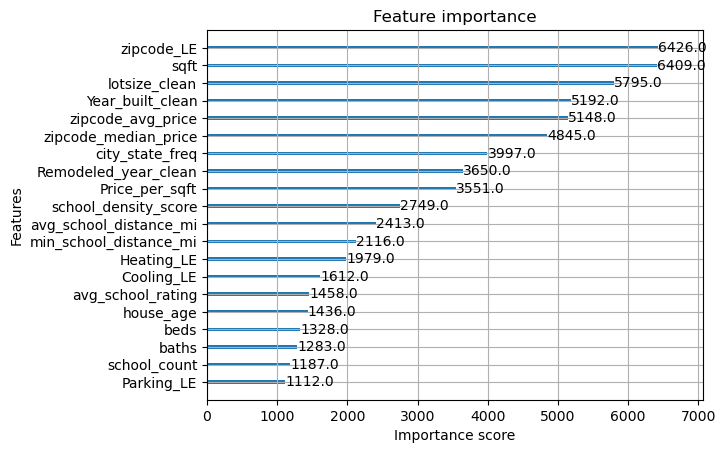

In [7]:
#Анализ важности признаков

import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(final_model, max_num_features=20, importance_type='weight')
plt.show()

In [9]:
#Прогнозирование новых объектов

#y_new_pred_log = final_model.predict(X_new)
#y_new_pred = np.exp(y_new_pred_log)

In [10]:
# --------------------------
# Прогнозирование на тестовых данных
# --------------------------
X_new = X_test.copy()  # используем тестовый набор как "новые объекты"

# Прогнозируем логарифм цены
y_new_pred_log = final_model.predict(X_new)

# Переводим обратно в реальные цены
y_new_pred = np.exp(y_new_pred_log)

# Создаем DataFrame с результатами
predictions = X_new.copy()
predictions['pred_price'] = y_new_pred

# Сортируем по цене
top_10_expensive = predictions.sort_values(by='pred_price', ascending=False).head(10)
top_10_cheap = predictions.sort_values(by='pred_price', ascending=True).head(10)

# Выводим результаты
print("Топ-10 самых дорогих домов (по прогнозу):")
print(top_10_expensive[['pred_price']])

print("\nТоп-10 самых дешевых домов (по прогнозу):")
print(top_10_cheap[['pred_price']])


Топ-10 самых дорогих домов (по прогнозу):
        pred_price
332184  57085448.0
224403  54301088.0
50349   42804472.0
341089  39132424.0
157487  38052496.0
335707  35806860.0
157725  35490280.0
287941  33847368.0
68357   32003348.0
312856  31273800.0

Топ-10 самых дешевых домов (по прогнозу):
        pred_price
293490  554.892395
168408  612.014832
198313  644.057617
220120  675.674805
42126   681.522095
279612  705.083130
254784  714.362976
270400  714.637512
172771  789.147095
179539  842.350281


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24316\2456688135.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


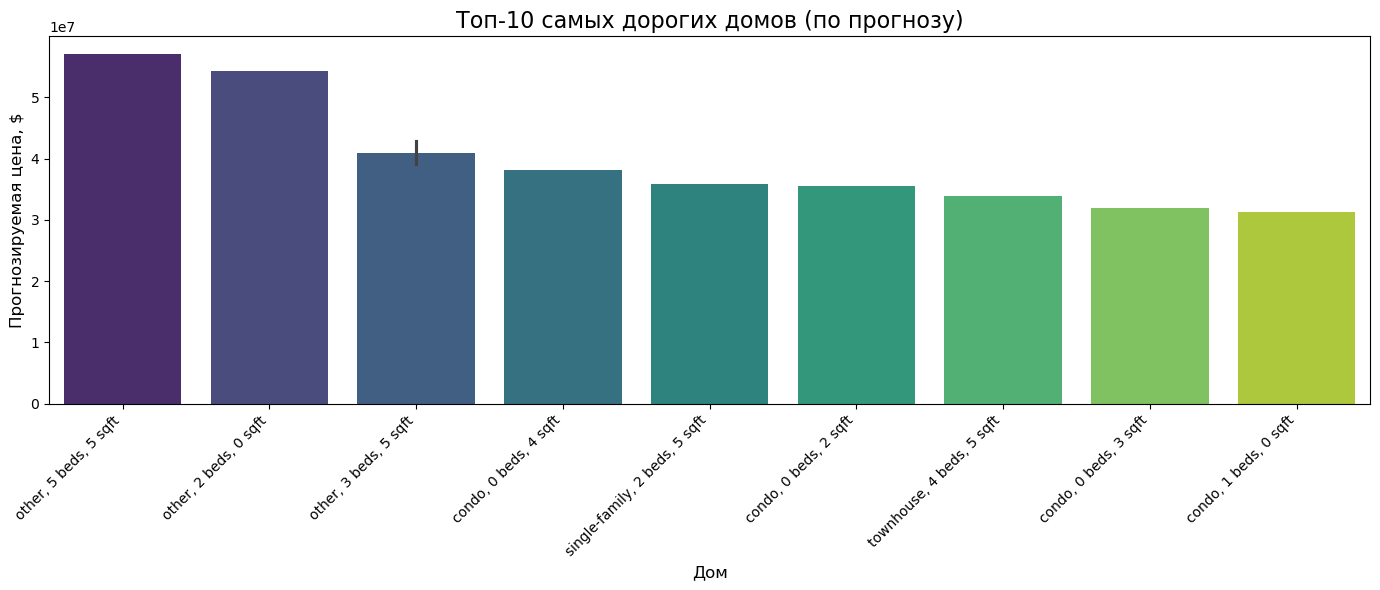

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24316\2456688135.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


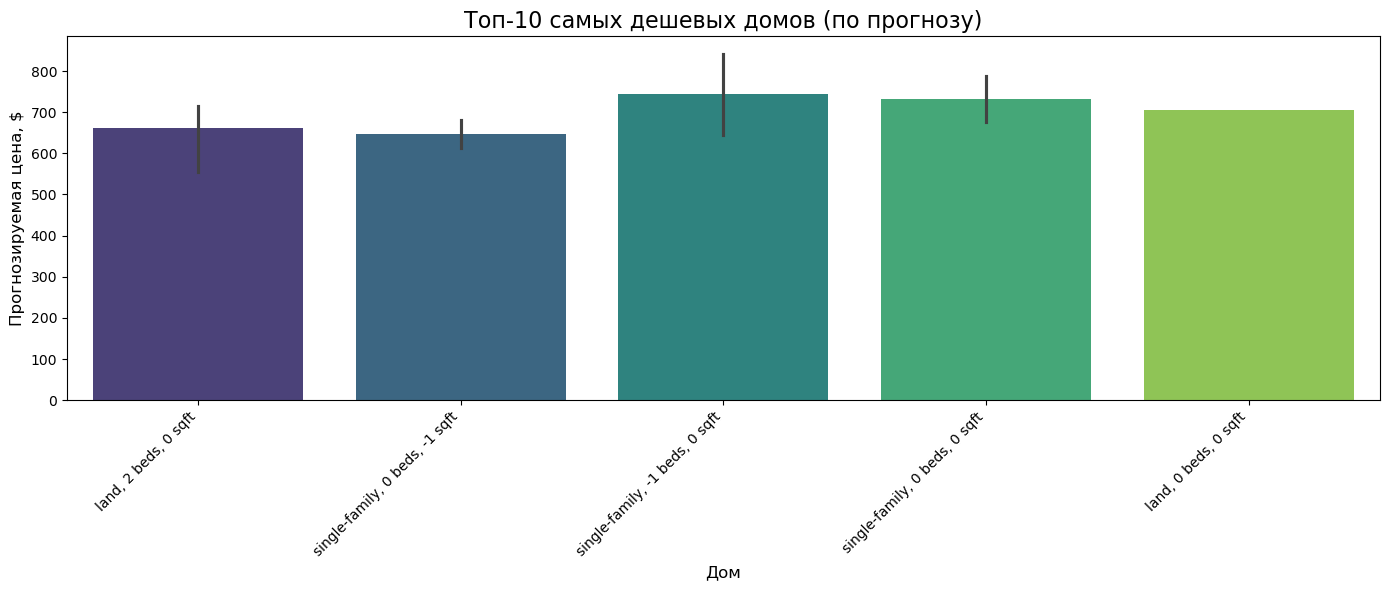

Топ-10 дорогих домов:


,sqft,beds,baths,stories,has_private_pool,has_fireplace,Price_per_sqft,lotsize_clean,Year_built_clean,house_age,Remodeled_year_clean,years_since_remodel,Heating_LE,Cooling_LE,Parking_LE,zipcode_avg_price,zipcode_median_price,zipcode_LE,pred_price
0,5.717715,5.993879,3.843350,0.181673,True,True,2600.0,122403.6,1939.0,86.0,1990.0,35.0,6.0,1.0,10.0,15.264204,15.590463,3649,57085448.0
1,-0.260879,2.423935,2.767178,0.181673,False,True,174.0,9381.0,1928.0,97.0,2004.0,21.0,8.0,7.0,8.0,14.786781,14.688894,113,54301088.0
2,5.717715,3.316421,3.843350,0.181673,True,True,2647.0,110642.4,1988.0,37.0,1995.0,30.0,6.0,1.0,10.0,15.586808,15.487441,3652,42804472.0
3,5.717715,3.316421,3.305264,1.552944,True,False,2036.0,179902.8,1965.0,60.0,1980.0,45.0,4.0,1.0,8.0,14.104350,14.037855,1448,39132424.0
4,4.242752,0.638963,2.229093,4.295486,False,False,174.0,8912.0,2019.0,6.0,2004.0,21.0,0.0,0.0,0.0,14.859042,14.825272,87,38052496.0
5,5.717715,2.423935,3.843350,0.181673,True,True,174.0,77101.2,1925.0,100.0,1977.5,47.5,5.0,1.0,10.0,15.586808,15.487441,3652,35806860.0
6,2.971936,0.638963,1.152921,4.295486,True,False,174.0,9381.0,2013.0,12.0,2004.0,21.0,0.0,1.0,0.0,14.642975,14.389312,91,35490280.0
7,5.717715,4.208907,2.229093,4.295486,False,False,2425.0,2146.0,1901.0,124.0,2007.0,18.0,8.0,7.0,8.0,14.680269,14.444031,92,33847368.0
8,3.251180,0.638963,1.152921,0.181673,True,False,174.0,9381.0,2019.0,6.0,2004.0,21.0,0.0,1.0,0.0,14.642975,14.389312,91,32003348.0
9,-0.260879,1.531449,2.229093,4.295486,False,False,174.0,9381.0,1882.0,143.0,2004.0,21.0,8.0,7.0,8.0,15.412325,15.393405,86,31273800.0


Топ-10 дешевых домов:


,sqft,beds,baths,stories,has_private_pool,has_fireplace,Price_per_sqft,lotsize_clean,Year_built_clean,house_age,Remodeled_year_clean,years_since_remodel,Heating_LE,Cooling_LE,Parking_LE,zipcode_avg_price,zipcode_median_price,zipcode_LE,pred_price
0,-0.023194,2.423935,-0.461336,0.181673,False,False,174.0,2125.0,1890.0,135.0,1975.0,50.0,9.0,0.0,0.0,10.233549,11.848422,290,554.892395
1,-1.027889,-0.253523,-0.461336,-1.189598,False,False,174.0,3049.0,1925.0,100.0,2016.0,9.0,5.0,0.0,0.0,10.249914,11.154835,2251,612.014832
2,-0.972478,-1.146009,-0.461336,-1.189598,False,False,174.0,3049.0,1926.0,99.0,2016.0,9.0,5.0,0.0,10.0,10.249914,11.154835,2251,644.057617
3,-0.929461,0.638963,-0.461336,-1.189598,False,False,174.0,3049.0,1925.0,100.0,2016.0,9.0,5.0,0.0,0.0,10.249914,11.154835,2251,675.674805
4,-1.043200,-0.253523,-0.461336,-1.189598,False,False,174.0,3920.0,1924.0,101.0,2016.0,9.0,5.0,0.0,0.0,10.249914,11.154835,2251,681.522095
5,-0.260879,-0.253523,-0.461336,0.181673,False,False,174.0,999.0,1920.5,104.5,1975.0,50.0,0.0,0.0,0.0,9.842866,10.559351,282,705.083130
6,-0.260879,2.423935,-0.461336,0.181673,False,False,174.0,3708.0,1886.0,139.0,1975.0,50.0,0.0,0.0,0.0,9.842866,10.559351,282,714.362976
7,-0.260879,2.423935,-0.461336,0.181673,False,False,174.0,3750.0,1887.0,138.0,1975.0,50.0,9.0,0.0,0.0,10.233549,11.848422,290,714.637512
8,-0.739167,-0.253523,-0.461336,0.181673,False,False,174.0,3049.0,1919.0,106.0,2016.0,9.0,9.0,0.0,0.0,8.351379,6.908755,2243,789.147095
9,-0.904672,-1.146009,-0.461336,-1.189598,False,False,174.0,3920.0,1970.0,55.0,2016.0,9.0,5.0,0.0,0.0,8.923740,8.517393,2242,842.350281


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Подготовка данных: добавляем прогнозные цены в X_test
X_test_pred = X_test.copy()
X_test_pred['pred_price'] = np.exp(final_model.predict(X_test))

# Топ-10 дорогих домов
top_10_expensive = X_test_pred.nlargest(10, 'pred_price').reset_index(drop=True)

# Топ-10 дешевых домов
top_10_cheap = X_test_pred.nsmallest(10, 'pred_price').reset_index(drop=True)

# Функция для создания логичного наименования дома
def make_house_label(row):
    # Определяем тип дома
    property_type_cols = [col for col in X_test_pred.columns if col.startswith('propertyType_')]
    property_type = [col.replace('propertyType_', '') for col in property_type_cols if row[col]==1]
    property_type = property_type[0] if property_type else 'Unknown'
    return f"{property_type}, {int(row['beds'])} beds, {int(row['sqft'])} sqft"

# Добавляем логичные наименования для графика
top_10_expensive['House'] = top_10_expensive.apply(make_house_label, axis=1)
top_10_cheap['House'] = top_10_cheap.apply(make_house_label, axis=1)

# Функция для визуализации
def plot_top_homes(df, title):
    plt.figure(figsize=(14,6))
    sns.barplot(
        x='House', 
        y='pred_price', 
        data=df,
        palette='viridis'
    )
    plt.title(title, fontsize=16)
    plt.ylabel('Прогнозируемая цена, $', fontsize=12)
    plt.xlabel('Дом', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Визуализация топ-10 дорогих домов
plot_top_homes(top_10_expensive, "Топ-10 самых дорогих домов (по прогнозу)")

# Визуализация топ-10 дешевых домов
plot_top_homes(top_10_cheap, "Топ-10 самых дешевых домов (по прогнозу)")

# Таблица с ключевыми характеристиками для анализа
features = [
    'sqft', 'beds', 'baths', 'stories', 'has_private_pool', 'has_fireplace',
    'Price_per_sqft', 'lotsize_clean', 'Year_built_clean', 'house_age',
    'Remodeled_year_clean', 'years_since_remodel', 'Heating_LE', 'Cooling_LE', 
    'Parking_LE', 'zipcode_avg_price', 'zipcode_median_price', 'zipcode_LE', 'pred_price'
]

print("Топ-10 дорогих домов:")
display(top_10_expensive[features])

print("Топ-10 дешевых домов:")
display(top_10_cheap[features])



In [12]:
# Список всех колонок X_test
print(X_test.columns)


Index(['baths', 'sqft', 'beds', 'stories', 'has_private_pool', 'has_fireplace',
       'status_active', 'status_coming soon', 'status_new', 'status_other',
       'status_pending', 'status_sold', 'propertyType_apartment',
       'propertyType_bungalow', 'propertyType_cabin', 'propertyType_condo',
       'propertyType_coop', 'propertyType_farm', 'propertyType_land',
       'propertyType_mobile', 'propertyType_multi-family',
       'propertyType_other', 'propertyType_ranch',
       'propertyType_single-family', 'propertyType_townhouse',
       'propertyType_villa', 'city_state_freq', 'school_count',
       'avg_school_rating', 'best_school_rating', 'avg_school_distance_mi',
       'min_school_distance_mi', 'school_rating_combined',
       'school_density_score', 'has_school', 'Price_per_sqft', 'lotsize_clean',
       'Year_built_clean', 'house_age', 'Remodeled_year_clean',
       'years_since_remodel', 'Heating_LE', 'Cooling_LE', 'Parking_LE',
       'zipcode_avg_price', 'zipcode_median_

In [14]:
import pandas as pd
import numpy as np

# Прогнозируем логарифм цены и переводим обратно в реальные единицы
y_test_pred_log = final_model.predict(X_test)
y_test_pred = np.exp(y_test_pred_log)

# Добавляем прогноз в DataFrame
X_test_with_pred = X_test.copy()
X_test_with_pred['pred_price'] = y_test_pred

# Сохраняем индекс как отдельный столбец
X_test_with_pred['house_id'] = X_test_with_pred.index

# Сортируем по цене
top_10_expensive = X_test_with_pred.sort_values(by='pred_price', ascending=False).head(10)
top_10_cheap = X_test_with_pred.sort_values(by='pred_price', ascending=True).head(10)

# Выбираем нужные колонки
features = ['house_id', 'sqft', 'beds', 'baths', 'stories', 'has_private_pool', 'zipcode_LE', 'pred_price']

print("Топ-10 дорогих домов:")
display(top_10_expensive[features])

print("\nТоп-10 дешевых домов:")
display(top_10_cheap[features])

# Интерпретация: средние характеристики для топ-10
expensive_summary = top_10_expensive[['sqft','beds','baths','stories','has_private_pool','pred_price']].mean()
cheap_summary = top_10_cheap[['sqft','beds','baths','stories','has_private_pool','pred_price']].mean()

print("\nСредние характеристики топ-10 дорогих домов:")
print(expensive_summary)

print("\nСредние характеристики топ-10 дешевых домов:")
print(cheap_summary)


Топ-10 дорогих домов:


,house_id,sqft,beds,baths,stories,has_private_pool,zipcode_LE,pred_price
332184,332184,5.717715,5.993879,3.843350,0.181673,True,3649,57085448.0
224403,224403,-0.260879,2.423935,2.767178,0.181673,False,113,54301088.0
50349,50349,5.717715,3.316421,3.843350,0.181673,True,3652,42804472.0
341089,341089,5.717715,3.316421,3.305264,1.552944,True,1448,39132424.0
157487,157487,4.242752,0.638963,2.229093,4.295486,False,87,38052496.0
335707,335707,5.717715,2.423935,3.843350,0.181673,True,3652,35806860.0
157725,157725,2.971936,0.638963,1.152921,4.295486,True,91,35490280.0
287941,287941,5.717715,4.208907,2.229093,4.295486,False,92,33847368.0
68357,68357,3.251180,0.638963,1.152921,0.181673,True,91,32003348.0
312856,312856,-0.260879,1.531449,2.229093,4.295486,False,86,31273800.0



Топ-10 дешевых домов:


,house_id,sqft,beds,baths,stories,has_private_pool,zipcode_LE,pred_price
293490,293490,-0.023194,2.423935,-0.461336,0.181673,False,290,554.892395
168408,168408,-1.027889,-0.253523,-0.461336,-1.189598,False,2251,612.014832
198313,198313,-0.972478,-1.146009,-0.461336,-1.189598,False,2251,644.057617
220120,220120,-0.929461,0.638963,-0.461336,-1.189598,False,2251,675.674805
42126,42126,-1.043200,-0.253523,-0.461336,-1.189598,False,2251,681.522095
279612,279612,-0.260879,-0.253523,-0.461336,0.181673,False,282,705.083130
254784,254784,-0.260879,2.423935,-0.461336,0.181673,False,282,714.362976
270400,270400,-0.260879,2.423935,-0.461336,0.181673,False,290,714.637512
172771,172771,-0.739167,-0.253523,-0.461336,0.181673,False,2243,789.147095
179539,179539,-0.904672,-1.146009,-0.461336,-1.189598,False,2242,842.350281



Средние характеристики топ-10 дорогих домов:
sqft                3.853268e+00
beds                2.513184e+00
baths               2.659561e+00
stories             1.964325e+00
has_private_pool    6.000000e-01
pred_price          3.997976e+07
dtype: float64

Средние характеристики топ-10 дешевых домов:
sqft                 -0.642270
beds                  0.460466
baths                -0.461336
stories              -0.503962
has_private_pool      0.000000
pred_price          693.374207
dtype: float64


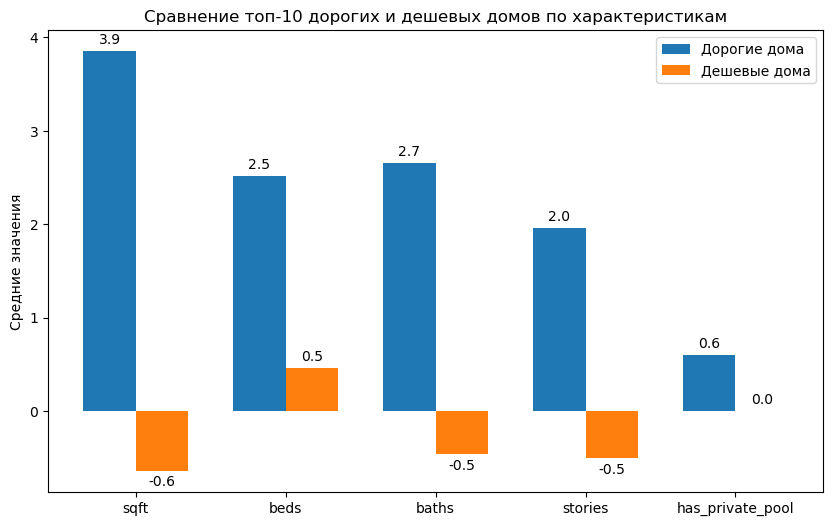

In [15]:
import matplotlib.pyplot as plt

# Подготовим данные для графика
comparison_features = ['sqft', 'beds', 'baths', 'stories', 'has_private_pool']
expensive_avg = top_10_expensive[comparison_features].mean()
cheap_avg = top_10_cheap[comparison_features].mean()

# Настройка графика
x = np.arange(len(comparison_features))
width = 0.35  # ширина колонок

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, expensive_avg, width, label='Дорогие дома')
rects2 = ax.bar(x + width/2, cheap_avg, width, label='Дешевые дома')

# Подписи и оформление
ax.set_ylabel('Средние значения')
ax.set_title('Сравнение топ-10 дорогих и дешевых домов по характеристикам')
ax.set_xticks(x)
ax.set_xticklabels(comparison_features)
ax.legend()
ax.bar_label(rects1, fmt='%.1f', padding=3)
ax.bar_label(rects2, fmt='%.1f', padding=3)

plt.show()


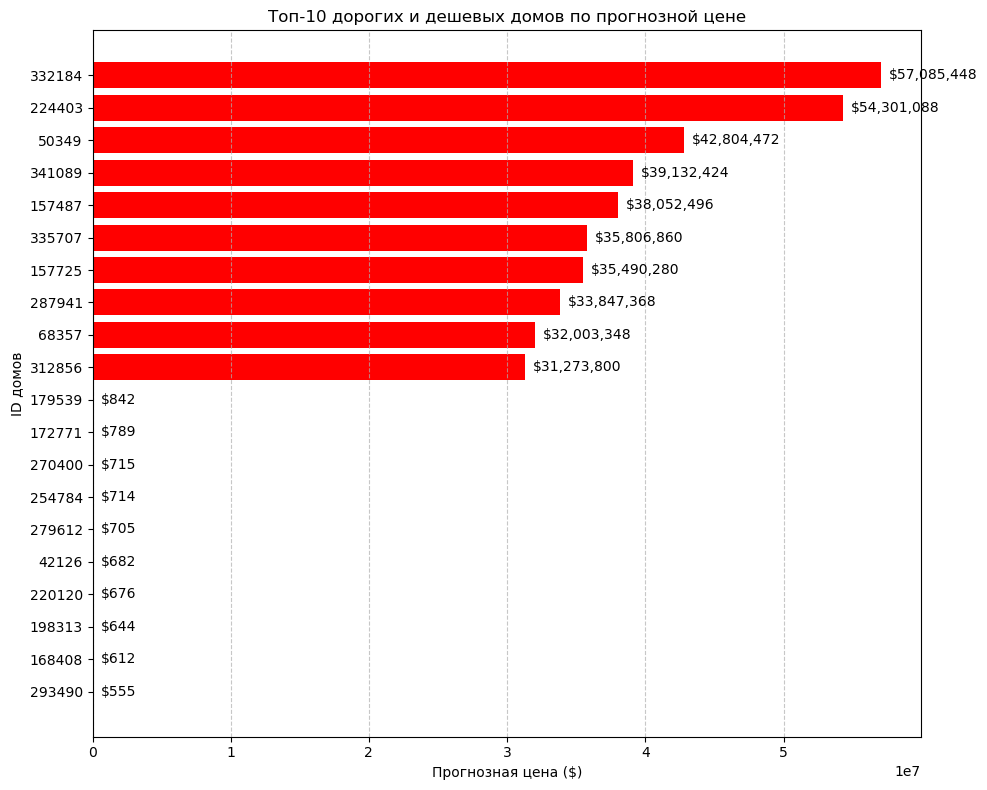

In [16]:
import matplotlib.pyplot as plt

# Объединим топ-10 дорогих и дешевых домов в один датафрейм для графика
top_expensive = top_10_expensive[['pred_price']].copy()
top_expensive['type'] = 'Дорогие'
top_cheap = top_10_cheap[['pred_price']].copy()
top_cheap['type'] = 'Дешевые'

top_combined = pd.concat([top_expensive, top_cheap])
top_combined = top_combined.sort_values('pred_price', ascending=True)  # сортируем по цене

# Горизонтальный столбчатый график
plt.figure(figsize=(10,8))
colors = top_combined['type'].map({'Дорогие':'red', 'Дешевые':'green'})
plt.barh(top_combined.index.astype(str), top_combined['pred_price'], color=colors)
plt.xlabel('Прогнозная цена ($)')
plt.ylabel('ID домов')
plt.title('Топ-10 дорогих и дешевых домов по прогнозной цене')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Добавим подписи с ценой
for i, v in enumerate(top_combined['pred_price']):
    plt.text(v + max(top_combined['pred_price'])*0.01, i, f"${v:,.0f}", va='center')

plt.tight_layout()
plt.show()


**Вывод:**

- Задача проекта в целом достигнута.

- Для публичного сервиса важно добавить:

1. Обработку выбросов (слишком дешевые или слишком дорогие объекты).

2. Возможность показать ключевые характеристики дома вместе с прогнозной ценой.

3. Визуализацию или сортировку домов по району, типу недвижимости и площади.

In [23]:
import json

# Результаты лучшего trial
best_trial = {
    "RMSE_log": 0.41155412324905566,
    "Params": {
        "n_estimators": 422,
        "max_depth": 10,
        "learning_rate": 0.12596801037948954,
        "gamma": 0.22835167790774402,
        "subsample": 0.8852853658470384,
        "colsample_bytree": 0.8340011916282545,
        "reg_alpha": 3.1015307570466115,
        "reg_lambda": 1.0590175785815306
    },
    "Train_metrics": {
        "R2": 0.91798755843189,
        "MAE": 0.19141782741496183,
        "RMSE_price_units": 932702.22
    },
    "Test_metrics": {
        "R2": 0.8731981831064215,
        "MAE": 0.22581191281121402,
        "RMSE_price_units": 991531.06
    }
}

# Сохраняем в JSON
with open("optuna_best_trial.json", "w") as f:
    json.dump(best_trial, f, indent=4)


In [24]:
print("Лучший trial Optuna:")
print(best_trial)

Лучший trial Optuna:
{'RMSE_log': 0.41155412324905566, 'Params': {'n_estimators': 422, 'max_depth': 10, 'learning_rate': 0.12596801037948954, 'gamma': 0.22835167790774402, 'subsample': 0.8852853658470384, 'colsample_bytree': 0.8340011916282545, 'reg_alpha': 3.1015307570466115, 'reg_lambda': 1.0590175785815306}, 'Train_metrics': {'R2': 0.91798755843189, 'MAE': 0.19141782741496183, 'RMSE_price_units': 932702.22}, 'Test_metrics': {'R2': 0.8731981831064215, 'MAE': 0.22581191281121402, 'RMSE_price_units': 991531.06}}
